<a href="https://colab.research.google.com/github/itimes-digital/deep-learning-estudo/blob/main/serie_temporal_mult_previsores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
base = pd.read_csv('https://raw.githubusercontent.com/itimes-digital/deep-learning-estudo/main/dataset/petr4_treinamento.csv')
base.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [4]:
base.dropna(inplace=True)

In [7]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242 entries, 0 to 1244
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1242 non-null   object 
 1   Open       1242 non-null   float64
 2   High       1242 non-null   float64
 3   Low        1242 non-null   float64
 4   Close      1242 non-null   float64
 5   Adj Close  1242 non-null   float64
 6   Volume     1242 non-null   float64
dtypes: float64(6), object(1)
memory usage: 77.6+ KB


In [5]:
base_treinamento = base.iloc[:, 1:7].values

In [6]:
scaler = MinMaxScaler(feature_range=(0,1));
base_treinamento_normalizado = scaler.fit_transform(base_treinamento);

In [12]:
previsores = []
preco_real = []

for i in range(180, 1242):
  previsores.append(base_treinamento_normalizado[i - 180: i, 0:6]);
  preco_real.append(base_treinamento_normalizado[i, 0])

In [13]:
previsores, preco_real = np.array(previsores), np.array(preco_real)
previsores.shape

(1062, 180, 6)

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [21]:
model = Sequential();
model.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 6)));
model.add(Dropout(0.3));

model.add(LSTM(units = 50, return_sequences = True));
model.add(Dropout(0.3));

model.add(LSTM(units = 50, return_sequences = True));
model.add(Dropout(0.3));

model.add(LSTM(units = 50));
model.add(Dropout(0.3));

model.add(Dense(units = 1, activation = 'sigmoid'));
model.compile(optimizer = 'adam', 
              loss = 'mean_squared_error', 
              metrics = ['mean_absolute_error'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 180, 100)          42800     
_________________________________________________________________
dropout (Dropout)            (None, 180, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 180, 50)           30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 180, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 180, 50)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [22]:
# Funções para melhorar o modelo
es = EarlyStopping(monitor = 'loss', 
                   min_delta = 1e-10, 
                   patience = 10,
                   verbose = 1)

rlr = ReduceLROnPlateau(monitor = 'loss',
                        factor = 0.2,
                        patience = 5,
                        verbose = 1)

mcp = ModelCheckpoint(filepath = 'pesos.h5',
                      monitor = 'loss',
                      save_best_only = True,
                      verbose = 1)

In [ ]:
history_ = model.fit(previsores, 
                    preco_real, 
                    epochs = 100, 
                    batch_size = 32, 
                    callbacks = [es, rlr, mcp])

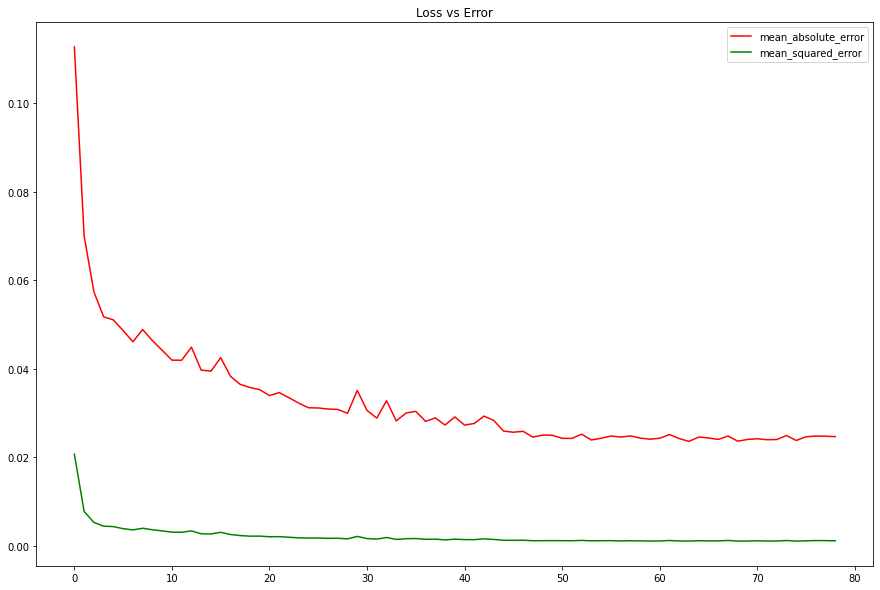

In [24]:
plt.figure(figsize = (15, 10))
plt.plot(history_.history['mean_absolute_error'], color = 'red', label = 'mean_absolute_error')
plt.plot(history_.history['loss'], color = 'green', label = 'mean_squared_error')
plt.title('Loss vs Error')
plt.legend()
plt.show()

In [46]:
np.sum(history_.history['mean_absolute_error']) - np.sum(history_.history['loss'])

2.3949268808355555

In [47]:
np.mean(history_.history['mean_absolute_error']) - np.mean(history_.history['loss'])

0.03031553013715893

In [25]:
base_teste = pd.read_csv('https://raw.githubusercontent.com/itimes-digital/deep-learning-estudo/main/dataset/petr4_teste.csv')
base_teste.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [26]:
base_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       22 non-null     object 
 1   Open       22 non-null     float64
 2   High       22 non-null     float64
 3   Low        22 non-null     float64
 4   Close      22 non-null     float64
 5   Adj Close  22 non-null     float64
 6   Volume     22 non-null     int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ KB


In [27]:
preco_real_teste = base_teste.iloc[:, 1:2].values

frames = [base, base_teste]

base_completa = pd.concat(frames)
base_completa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


In [29]:
base_completa.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17,2018-01-25,19.340000,19.340000,19.340000,19.340000,19.301397,0.0
18,2018-01-26,19.620001,19.980000,19.100000,19.930000,19.890221,81989500.0
19,2018-01-29,19.670000,20.049999,19.570000,19.850000,19.810381,55726200.0
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,19.451097,46203000.0
21,2018-01-31,19.740000,19.930000,19.680000,19.700001,19.660681,41576600.0


In [28]:
base_completa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264 entries, 0 to 21
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1264 non-null   object 
 1   Open       1264 non-null   float64
 2   High       1264 non-null   float64
 3   Low        1264 non-null   float64
 4   Close      1264 non-null   float64
 5   Adj Close  1264 non-null   float64
 6   Volume     1264 non-null   float64
dtypes: float64(6), object(1)
memory usage: 79.0+ KB


In [30]:
base_completa = base_completa.drop('Date', axis = 1);

In [31]:
entradas = base_completa[len(base_completa) - len(base_teste) - 180:].values;

In [32]:
entradas = scaler.transform(entradas);

In [33]:
entradas.shape

(202, 6)

In [34]:
x_teste = []

for i in range(180, 202):
  x_teste.append(entradas[i - 180: i, 0:6])

x_teste = np.array(x_teste)

In [36]:
x_teste.shape

(22, 180, 6)

In [37]:
previsoes = model.predict(x_teste)

In [38]:
scaler_previsao = MinMaxScaler(feature_range = (0,1))
scaler_previsao.fit_transform(base_treinamento[:, 0:1])

array([[0.76501938],
       [0.7562984 ],
       [0.78149225],
       ...,
       [0.57122093],
       [0.57655039],
       [0.57655039]])

In [39]:
previsoes = scaler_previsao.inverse_transform(previsoes)

In [40]:
previsoes.mean()

17.722078

In [41]:
preco_real_teste.mean()

17.87454563636364

In [42]:
preco_real_teste.mean() - previsoes.mean()

0.15246731299938077

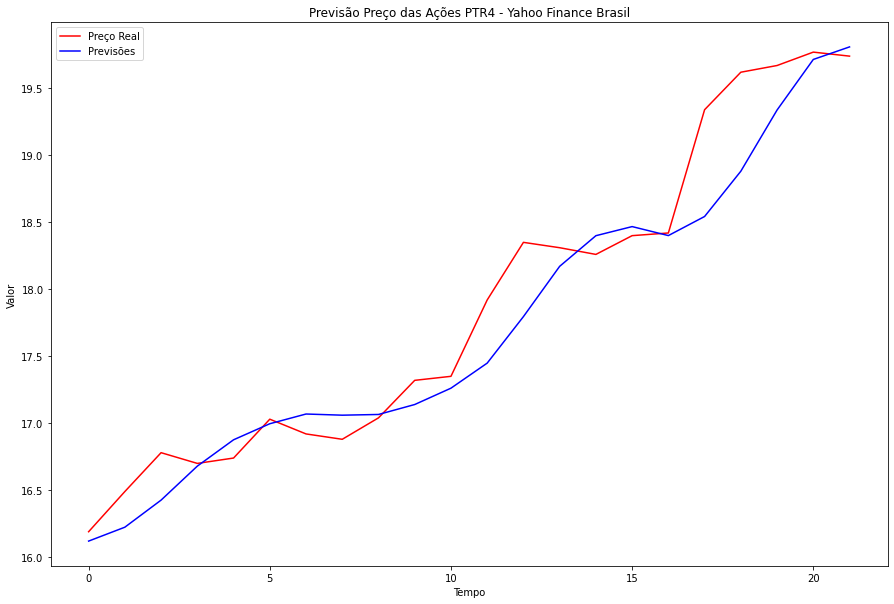

In [45]:
plt.figure(figsize = (15,10))
plt.plot(preco_real_teste, color = 'red', label = 'Preço Real');
plt.plot(previsoes, color = 'blue', label = 'Previsões');
plt.title('Previsão Preço das Ações PTR4 - Yahoo Finance Brasil');
plt.xlabel('Tempo');
plt.ylabel('Valor');
plt.legend();
plt.show();